In [86]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm

import utils.data_processing as dp
import matplotlib.pyplot as plt

from utils.UNeXt import UNet
from utils.loss import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build dataset

In [93]:
batch_size = 8
num_workers = 8

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

# Dataset
directory  = './data/ZyxAct_16kPa_small/'
test_cells = 'cell_3'


in_channels  = [[6],[7]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (2,3) 
transform_kwargs = {'crop_size': 256,
                    'output_channels': out_channels, 
                    'vector_components': [out_channels, (0,1)],
                    'magnitude_only': False,
                    'angmag': True,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.4},
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 200,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True,
                    'exclude_frames': [31,90]
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [94]:
df = dataset.info.copy()

df.head(10)

,index,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in,F_mean,F_max
0,0,cell_0,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
1,1,cell_0,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
2,2,cell_0,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
3,3,cell_0,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
4,4,cell_0,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
5,5,cell_0,Disp_Trac_CellMask_ForceMask_Actin_5.npy,5,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
6,6,cell_0,Disp_Trac_CellMask_ForceMask_Actin_6.npy,6,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
7,7,cell_0,Disp_Trac_CellMask_ForceMask_Actin_7.npy,7,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
8,8,cell_0,Disp_Trac_CellMask_ForceMask_Actin_8.npy,8,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516
9,9,cell_0,Disp_Trac_CellMask_ForceMask_Actin_9.npy,9,./data/ZyxAct_16kPa_small/,0.0,0.0,5.212261,129.156811,76.050815,509.421164,205.322983,3474.241516


In [95]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_3']}
[163 127 123 168 132 125 154 144 179 180 139 167 164 147 176 130 134 177
 172 137 138 182 153 142 124 148 175 122 165 149 146 152 140 156 133 131
 162 158 128 178]


{'mask': torch.Size([1, 256, 256]), 'zyxin': torch.Size([1, 256, 256]), 'actin': torch.Size([1, 256, 256]), 'output': torch.Size([2, 256, 256]), 'displacements': torch.Size([2, 256, 256])}


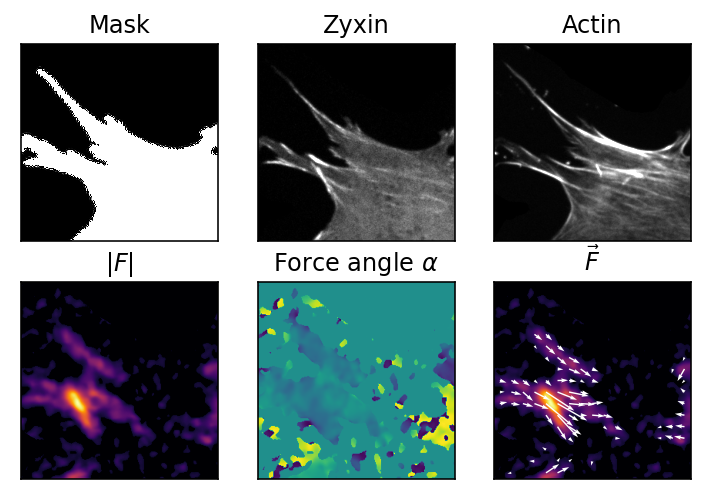

In [96]:
fig,ax=plt.subplots(2,3,figsize=(2*3, 2*2), dpi=144)

cell = 'cell_0'
frame = 14

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.

sample = dataset[idx] # get item

print({key: sample[key].shape for key in sample.keys()})


ax[0][0].set_title('Mask')
ax[0][0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[0][1].set_title('Zyxin')
ax[0][1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=3, vmin=0)
ax[0][2].set_title('Actin')
ax[0][2].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1][0].set_title('$|F|$')
ax[1][0].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno')
ax[1][1].set_title('Force angle $\\alpha$')
ax[1][1].imshow(sample['output'].squeeze()[1], origin='lower', vmax=np.pi, vmin=-np.pi)
ax[1][2].set_title('$\\vec{F}$')
ax[1][2].imshow(sample['output'].squeeze()[0], origin='lower', cmap='inferno')
ax[1][2].quiver(*nb_utils.make_vector_field(*sample['output'].squeeze(), downsample=15, threshold=0.4, angmag=True), color='w', scale=20)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Build U-Net model with ConvNext blocks

In [97]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 3 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'am',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }


models = {}
for protein in ['zyxin', 'actin']:
    modelname = 'model_0'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 20}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein, 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}
LOSS KWARGS {'loss_type': 'am', 'exp_weight': 0.0, 'strainenergy_regularization': 0.0, 'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30}, 'loss_kwargs': {'max_force': 8.0}}


# Perform training

In [ ]:
save_models = False
n_epochs = 50

pbar = tqdm(total=n_epochs*len(dataset.train_indices))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))

    # SAVE
    if save_models:
        for mkey in models.keys():
            model[mkey].log_images(epoch=e)
            model[mkey].log_scalars(epoch=e) 
            
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            print("SAVING MODEL")
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )

  0%|          | 0/9150 [00:00<?, ?it/s]

Epoch 0:	 Time: 39.45 	(per epoch: 39.45)
Epoch 1:	 Time: 78.46 	(per epoch: 39.23)
Epoch 2:	 Time: 117.06 	(per epoch: 39.02)
Epoch 3:	 Time: 155.10 	(per epoch: 38.78)
Epoch 4:	 Time: 193.98 	(per epoch: 38.80)
Epoch 5:	 Time: 232.46 	(per epoch: 38.74)
Epoch 6:	 Time: 271.11 	(per epoch: 38.73)
Epoch 7:	 Time: 309.62 	(per epoch: 38.70)
Epoch 8:	 Time: 348.13 	(per epoch: 38.68)
Epoch 9:	 Time: 386.99 	(per epoch: 38.70)
Epoch 10:	 Time: 425.35 	(per epoch: 38.67)
